In [1]:
import argparse
import sys
import time
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.layers import Input
from keras import backend as K
from keras import regularizers
from keras.layers import Input, BatchNormalization, Dense, GaussianNoise
from keras.models import Model

Using TensorFlow backend.


In [8]:
!pip install pydrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 21.5MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth) 

In [0]:
download = drive.CreateFile({'id': '1XCsuyjLP2l04S9uNGIyOAbfeADU_mcJv'})
download.GetContentFile('mnist.npz')

In [0]:
class Generator:
    def __init__(self):
        # generator
        self.input = Input([100])
        layer = Dense(500, activation=K.softplus)(self.input)
        layer = BatchNormalization()(layer)
        layer = Dense(500, activation=K.softplus)(layer)
        layer = BatchNormalization()(layer)
        self.output = Dense(28 ** 2, activation=K.sigmoid, kernel_regularizer=regularizers.l2())(layer)
        self.model = Model(inputs=self.input, outputs=self.output)

In [0]:
class Discriminator:
    def __init__(self):
        # discriminator
        self.input = Input([28 ** 2])
        layer = GaussianNoise(stddev=0.3)(self.input)
        layer = Dense(1000)(layer)
        layer = GaussianNoise(stddev=0.5)(layer)
        layer = Dense(500)(layer)
        layer = GaussianNoise(stddev=0.5)(layer)
        layer = Dense(250)(layer)
        layer = GaussianNoise(stddev=0.5)(layer)
        layer = Dense(250)(layer)
        layer = GaussianNoise(stddev=0.5)(layer)
        layer = Dense(250)(layer)
        self.feature = Model(inputs=self.input, outputs=layer)
        layer = GaussianNoise(stddev=0.5)(layer)
        self.output = Dense(10)(layer)
        self.model = Model(inputs=self.input, outputs=self.output)

In [0]:
def noise_gen(batch_size, z_dim):
    noise = np.zeros((batch_size, z_dim), dtype=np.float32)
    for i in range(batch_size):
        noise[i, :] = np.random.uniform(0, 1, z_dim)
    return noise

In [0]:
# arguments
#parser = argparse.ArgumentParser()
#parser.add_argument('--seed', type=int, default=1)
#parser.add_argument('--seed_data', type=int, default=1)
#parser.add_argument('--unlabeled_weight', type=float, default=1.)
#parser.add_argument('--batch_size', type=int, default=100)
#parser.add_argument('--count', type=int, default=10)
#args = parser.parse_args()
#print(args)

In [0]:
seed = 1
seed_data = 1
unlabeled_weight = 1
batch_size = 100
count =10

In [0]:
# load MNIST data
data = np.load('mnist.npz')
trainx = np.concatenate([data['x_train'], data['x_valid']], axis=0)
trainx_unl = trainx.copy()
trainx_unl2 = trainx.copy()
trainy = np.concatenate([data['y_train'], data['y_valid']]).astype(np.int32)
#nr_batches_train = int(trainx.shape[0] / args.batch_size)
nr_batches_train = int(trainx.shape[0] / batch_size)
testx = data['x_test']
testy = data['y_test'].astype(np.int32)
testy = np.reshape(testy, [testy.shape[0], 1])
#nr_batches_test = int(testx.shape[0] / args.batch_size)
nr_batches_test = int(testx.shape[0] / batch_size)

In [0]:
# select labeled data
rng = np.random.RandomState(seed)
data_rng = np.random.RandomState(seed_data)
inds = data_rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:count])
    tys.append(trainy[trainy == j][:count])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)

In [0]:
# set up tensorflow and keras
sess = tf.Session()
K.set_session(sess)
K.set_learning_phase(1)

In [0]:
# network
discriminator_model = Discriminator()
discriminator = discriminator_model.model
discriminator_feature = discriminator_model.feature
generator_model = Generator()
generator = generator_model.model

In [0]:
# loss function computation
x_label = Input([28 ** 2])
x_unlabel = Input([28 ** 2])
labels = Input([1], dtype=tf.int32)
noise = Input([100])
fake_image = generator(noise)
output_before_softmax_label = discriminator(x_label)
output_before_softmax_unlabel = discriminator(x_unlabel)
output_before_softmax_fake = discriminator(fake_image)

In [0]:
z_exp_label = tf.reduce_mean(tf.reduce_logsumexp(output_before_softmax_label))
z_exp_unlabel = tf.reduce_mean(tf.reduce_logsumexp(output_before_softmax_unlabel))
z_exp_fake = tf.reduce_mean(tf.reduce_logsumexp(output_before_softmax_fake))
index_flattened = tf.range(0, batch_size) * output_before_softmax_label.shape[1] + tf.reshape(labels, [batch_size])
l_label = tf.gather(tf.reshape(output_before_softmax_label, [-1]), index_flattened)
l_unlabel = tf.reduce_logsumexp(output_before_softmax_unlabel)
loss_label = -tf.reduce_mean(l_label) + tf.reduce_mean(z_exp_label)
loss_unlabel = -0.5 * tf.reduce_mean(l_unlabel) + 0.5 * tf.reduce_mean(tf.nn.softplus(l_unlabel)) + \
               0.5 * tf.reduce_mean(tf.nn.softplus(tf.reduce_logsumexp(output_before_softmax_fake)))
loss_discriminator = tf.add(loss_label, tf.multiply(loss_unlabel, unlabeled_weight))

In [0]:
feature_generated = tf.reduce_mean(discriminator_feature(fake_image), axis=0)
feature_real = tf.reduce_mean(discriminator_feature(x_unlabel), axis=0)
loss_generator = tf.reduce_mean(tf.square(feature_generated - feature_real))

In [0]:
train_err = tf.reduce_mean(
    tf.to_float(tf.not_equal(tf.argmax(output_before_softmax_label, axis=1), tf.cast(tf.reshape(labels, [batch_size]), tf.int64))))
test_error = tf.reduce_mean(
    tf.to_float(tf.not_equal(tf.argmax(output_before_softmax_label, axis=1), tf.cast(tf.reshape(labels, [batch_size]), tf.int64))))

In [23]:
# train settings
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
discriminator_gradients = discriminator_optimizer.compute_gradients(loss_discriminator, discriminator.trainable_weights)
# discriminator_grads_and_vars = zip(discriminator_gradients, discriminator.trainable_weights)
discriminator_train = discriminator_optimizer.apply_gradients(discriminator_gradients)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
generator_gradients = generator_optimizer.compute_gradients(loss_generator, generator.trainable_weights)
# generator_grads_and_vars = zip(generator_gradients, generator.trainable_weights)
generator_train = generator_optimizer.apply_gradients(generator_gradients)

In [0]:
sess.run(tf.global_variables_initializer())

In [26]:
for epoch in range(300):
    begin = time.time()

    # construct randomly permuted minibatches
    trainx = []
    trainy = []
    for t in range(int(trainx_unl.shape[0] / txs.shape[0])):
        inds = rng.permutation(txs.shape[0])
        trainx.append(txs[inds])
        trainy.append(tys[inds])
    trainx = np.concatenate(trainx, axis=0)
    trainy = np.concatenate(trainy, axis=0)
    trainy = np.reshape(trainy, [trainy.shape[0], 1])
    trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]
    trainx_unl2 = trainx_unl2[rng.permutation(trainx_unl2.shape[0])]

    # train
    loss_label_record = 0.
    loss_unlabel_record = 0.
    train_err_record = 0.
    for t in range(nr_batches_train):
        noise_feed = noise_gen(batch_size, 100)
        _, loss_label_this, loss_unlabel_this, train_err_this = sess.run(
            [discriminator_train, loss_label, loss_unlabel, train_err], feed_dict={
                x_label: trainx[t * batch_size:(t + 1) * batch_size],
                x_unlabel: trainx_unl[t * batch_size:(t + 1) * batch_size],
                labels: trainy[t * batch_size:(t + 1) * batch_size],
                noise: noise_feed
            })

        loss_label_record += loss_label_this
        loss_unlabel_record += loss_unlabel_this
        train_err_record += train_err_this

        noise_feed = noise_gen(batch_size, 100)
        _, loss_generator_this = sess.run([generator_train, loss_generator], feed_dict={
            noise: noise_feed,
            x_unlabel: trainx_unl2[t * batch_size:(t + 1) * batch_size]
        })
    loss_label_record /= nr_batches_train
    loss_unlabel_record /= nr_batches_train
    train_err_record /= nr_batches_train

    # test
    test_err_record = 0.
    for t in range(nr_batches_test):
        test_err_this = sess.run(test_error, feed_dict={
            x_label: testx[t * batch_size:(t + 1) * batch_size],
            labels: testy[t * batch_size:(t + 1) * batch_size]
        })
        test_err_record += test_err_this
    test_err_record /= nr_batches_test

    # report
    if (epoch%100 = 0):
      print("Iteration %d, time = %ds, loss_lab = %.4f, loss_unl = %.4f, train err = %.4f, test err = %.4f" % (
          epoch, time.time() - begin, loss_label_record, loss_unlabel_record, train_err_record, test_err_record))
      plot_images(generator)
    sys.stdout.flush()

Iteration 0, time = 10s, loss_lab = 6.8137, loss_unl = 0.5532, train err = 0.2790, test err = 0.3787
Iteration 1, time = 9s, loss_lab = 5.8442, loss_unl = 0.2848, train err = 0.0948, test err = 0.3382
Iteration 2, time = 9s, loss_lab = 5.5411, loss_unl = 0.2057, train err = 0.0479, test err = 0.3403
Iteration 3, time = 9s, loss_lab = 5.3620, loss_unl = 0.1410, train err = 0.0284, test err = 0.3327
Iteration 4, time = 9s, loss_lab = 5.2990, loss_unl = 0.1271, train err = 0.0228, test err = 0.2915
Iteration 5, time = 9s, loss_lab = 5.2255, loss_unl = 0.1166, train err = 0.0169, test err = 0.3079
Iteration 6, time = 9s, loss_lab = 5.1833, loss_unl = 0.1077, train err = 0.0153, test err = 0.2937
Iteration 7, time = 9s, loss_lab = 5.1610, loss_unl = 0.1011, train err = 0.0134, test err = 0.2936
Iteration 8, time = 9s, loss_lab = 5.1392, loss_unl = 0.0926, train err = 0.0126, test err = 0.3068
Iteration 9, time = 9s, loss_lab = 5.1243, loss_unl = 0.0895, train err = 0.0121, test err = 0.2935

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def plot_images(Generator, save2file=False, samples=25, step=0):
    filename = "./images/mnist_%d.png" % step
    #noise = np.random.normal(0, 1, (samples, 100))
    noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
    images = Generator.predict(noise)

    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(5, 5, i+1)
        #image = images[i, :, :, :]
        image = images[i, :]
        image = np.reshape(image, [28, 28])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

In [0]:
plt.show()

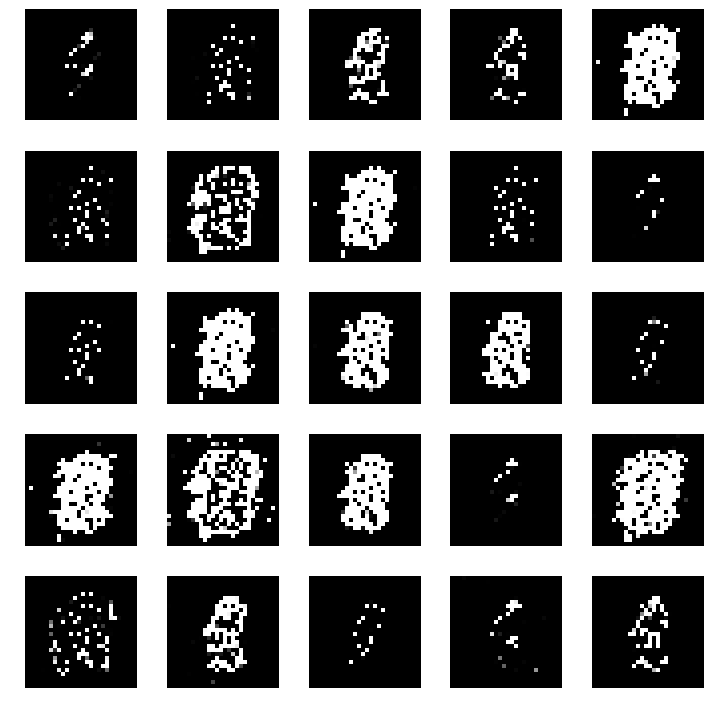

In [53]:
plot_images(generator)